In [67]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dtw import dtw
import pyarrow.parquet as pq
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
import pywt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

In [68]:
# suppress warnings

import warnings
warnings.filterwarnings('ignore')

Import database

In [69]:
# Set the folder path containing the Parquet files
folder_path = 'C:\DSGP_Git\PHM-Clustering\parquet files'

# Get a list of all Parquet file paths in the folder
file_paths = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.parquet')])

# Create an empty list to store the Pandas data frames
dfs = []

# Loop through the file paths, read each Parquet file as a Pandas data frame, and append it to the list
for file_path in file_paths:
    table = pq.read_table(file_path)
    df = table.to_pandas()
    dfs.append(df)

# Concatenate all Pandas data frames into a single data frame
df = pd.concat(dfs, ignore_index=True)

In [70]:
# The whole data frame is stored in `df`

df_pdmp = pd.DataFrame(df["pdmp"].tolist())   # Selecting the `pdmp` column
df_pin = pd.DataFrame(df["pin"].tolist())   # Selecting the `pin` column
df_po = pd.DataFrame(df["po"].tolist())   # Selecting the `po` column

In [71]:
# Assign "fault_class" values to y_true series

fault_true = df["fault_class"]

In [72]:
# Consider only first 1000 rows 
dfs = [df_pdmp, df_pin, df_po]
dfs_dtw = [df.head(3000) for df in dfs]
df_pdmp, df_pin, df_po = dfs_dtw

fault_true = df["fault_class"].head(3000)

In [73]:
# Function to apply background noise removal using wavelet transform

def denoise(x, wavelet='db4', level=1):
    # Apply wavelet decomposition
    coeffs = pywt.wavedec(x, wavelet, level=level)

    # Set threshold for coefficients
    threshold = np.sqrt(2 * np.log(len(x)))

    # Apply soft thresholding to detail coefficients
    coeffs[1:] = [pywt.threshold(i, value=threshold, mode='soft') for i in coeffs[1:]]

    # Reconstruct signal using inverse wavelet transform
    return pywt.waverec(coeffs, wavelet)

In [74]:
# Denoise the waves for each sensor dataframe using the denoise function
dfs = [df_pdmp, df_pin, df_po]
dfs_denoised = [pd.DataFrame(np.apply_along_axis(denoise, 1, df)) for df in dfs]

# Scale the data using standard scaler
scaler = StandardScaler()
scaled_dfs = [pd.DataFrame(scaler.fit_transform(df), index=df.index) for df in dfs_denoised]

In [75]:
# Apply PCA
pca = PCA(n_components=5)
pca_dfs = [pd.DataFrame(pca.fit_transform(df), index=df.index) for df in scaled_dfs]

In [77]:
# Define the number of clusters
n_clusters = 11

# Initialize a TimeSeriesKMeans object with DTW distance metric
dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")

# Loop through each PCA-transformed dataframe
for index, pca_df in enumerate(pca_dfs):
    # Get the start time
    start_time = time.time()
    
    # Fit the DTW clustering algorithm to the PCA-transformed data
    dtw.fit(pca_df)
    # Convert the resulting array to a dataframe
    pca_df = pd.DataFrame(pca_df)
    # Assign cluster labels to each row
    pca_df['cluster'] = dtw.labels_
    
    # Get the end time and print the execution time
    end_time = time.time()
    processing_time = end_time - start_time

    if index == 0:
        print(f"Processing time for pdmp sensor: {processing_time:.3f} seconds")
    elif index == 1:
        print(f"Processing time for pin sensor: {processing_time:.3f} seconds")
    elif index == 2:
        print(f"Processing time for po sensor: {processing_time:.3f} seconds")


Processing time for pdmp sensor: 50.022 seconds
Processing time for pin sensor: 40.422 seconds
Processing time for po sensor: 38.174 seconds


In [78]:
# Split pca_dfs into three dataframes and rename them
for i in range(3):
    df_name = f"df_dtw_{['pdmp', 'pin', 'po'][i]}"
    globals()[df_name] = pca_dfs[i]

Compare cluster label with actual fault label using a heatmap for each of the sensors

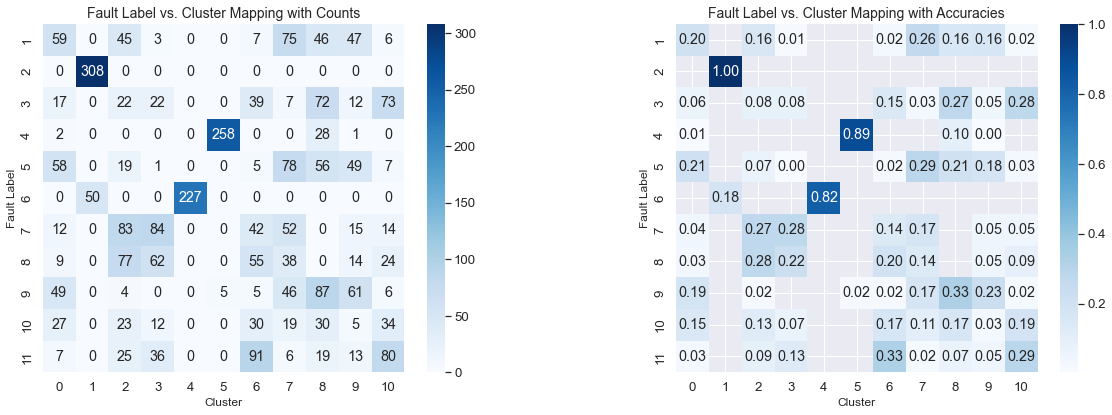

In [79]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_dtw_pdmp["cluster"])

# calculate the accuracy of each group
grouped = df_dtw_pdmp.groupby([fault_true, df_dtw_pdmp["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


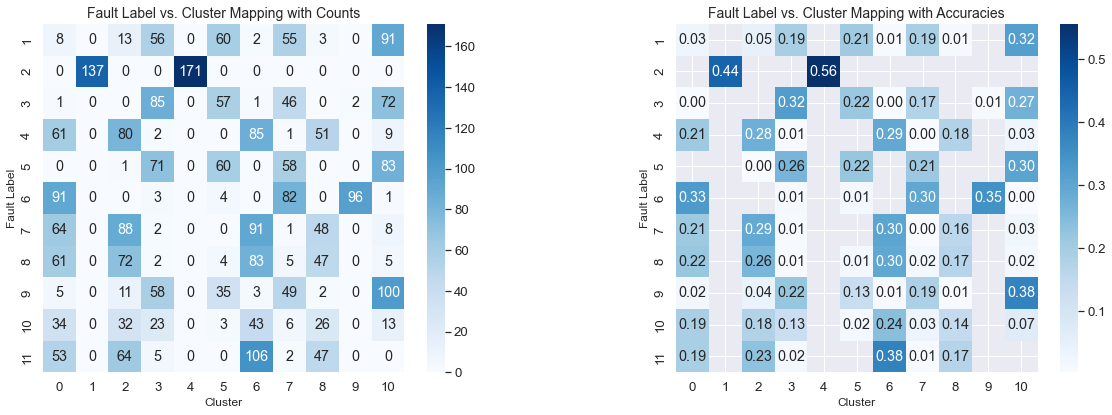

In [80]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_dtw_pin["cluster"])

# calculate the accuracy of each group
grouped = df_dtw_pin.groupby([fault_true, df_dtw_pin["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


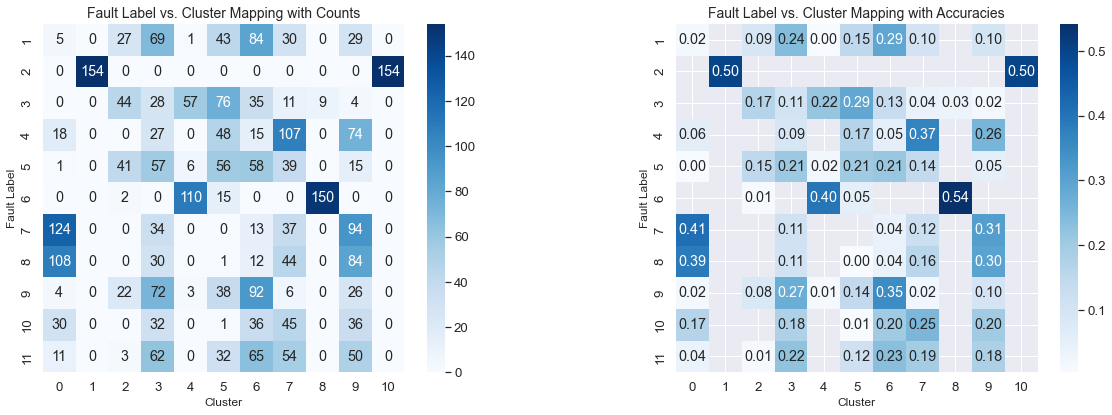

In [81]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(fault_true, df_dtw_po["cluster"])

# calculate the accuracy of each group
grouped = df_dtw_po.groupby([fault_true, df_dtw_po["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()